In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit -*-
# -*- date : 2023-11-25 -*-
# -*- Last revision: 2023-11-25 -*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarize results-*-

# <center> CS -433 Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Road Segmentation </center>
--- 

### Preparing environment for Google Colaboratory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/ml-project-2-team-slo/source

### Imports

In [10]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#import model parameters
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#import files
from data_processing import*
from visualization import visualize, visualize_patch
import constants

#import models
from cnn import Basic_CNN

In [12]:
# Set random seed for reproducibility
torch.manual_seed(0)

## 1. Data wrangling and visualization

In [21]:
myDatas = AdvancedProcessing(standardize=False)
myDatas.proceed()

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Done!
Creating dataloader...
Done!


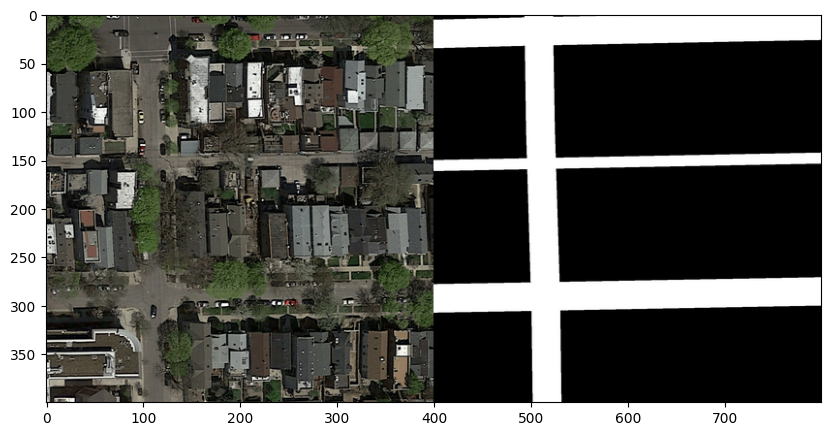

In [22]:
visualize(myDatas.imgs, myDatas.gt_imgs, index=4)

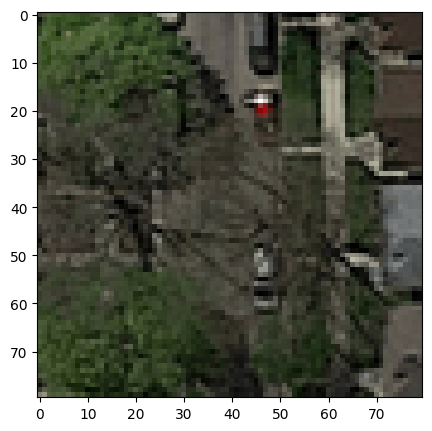

In [23]:
visualize_patch(myDatas.X_train[0].transpose(1,2,0))

## 2. Define and train model

In [ ]:
cnn = Basic_CNN(constants.WINDOW_SIZE)

# Define the loss function, optimizer and scheduler
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Train the model
cnn.train_model(
    optimizer, 
    scheduler, 
    criterion, 
    myDatas.train_dataloader, 
    myDatas.validate_dataloader, 
    num_epochs=10)